In [1]:
# imports and loading
from pymodulon.io import *
from pymodulon.plotting import *
from scipy.stats import fisher_exact, chi2_contingency
from statsmodels.stats.multitest import multipletests
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import squarify  # For treemap plotting
import sys
sys.path.insert(0, '../functions/matplotlib-extra-master/src')
import mpl_extra.treemap as tr

data_dir = path.join('..','data','processed_data')
interim_dir = path.join('..','data','interim')
ica_data = load_json_model(path.join(interim_dir,'zmo_raw.json.gz'))

QC_stats_df = pd.read_csv('../data/interim/metadata_qc_part2_all.tsv', delimiter = '\t')

/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' 

/tmp/ipykernel_582/3407953499.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


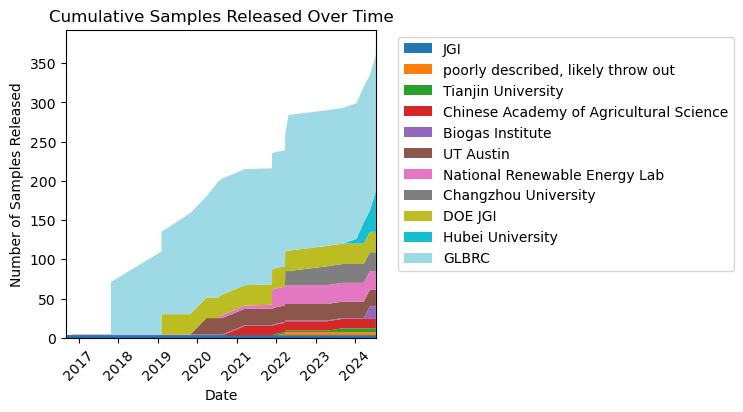

In [8]:
# Group by date and lab, then count samples
df_grouped = df.groupby(['run_date', 'lab']).size().unstack(fill_value=0)

# Convert index to date and sort
df_grouped.index = pd.to_datetime(df_grouped.index).date
df_grouped = df_grouped.sort_index()

# Calculate cumulative sums for each lab
cumulative_by_lab = df_grouped.cumsum()

# Sort labs by their final cumulative count (largest to smallest)
lab_totals = cumulative_by_lab.iloc[-1].sort_values(ascending=True)
sorted_labs = lab_totals.index

# Create color palette using tab20
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_labs)))

# Create the stacked area plot with sorted labs and custom colors
plt.figure(figsize=(4, 4))
plt.stackplot(cumulative_by_lab.index, 
             cumulative_by_lab[sorted_labs].T.values,
             labels=sorted_labs,
             colors=colors)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Samples Released')
plt.title('Cumulative Samples Released Over Time')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.xlim([cumulative_by_lab.index.min(), cumulative_by_lab.index.max()])
plt.ylim([0, cumulative_by_lab.sum(axis=1).max() * 1.05])

# Show plot
plt.savefig('../figures/released_samples.pdf', transparent=True, bbox_inches='tight')
plt.show()

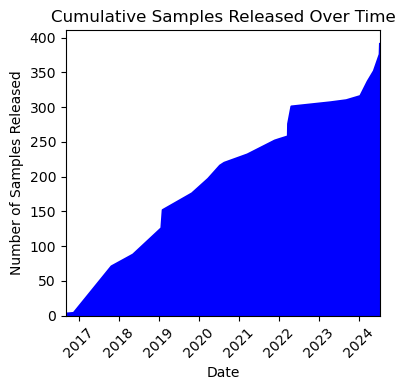

In [3]:
df = pd.read_csv('../data/raw_data/Zymomonas_mobilis.csv', index_col = 0, encoding='ISO-8859-1')

# Ensure 'energy_production_1' is a datetime object
df['run_date'] = pd.to_datetime(df['run_date'], errors='coerce')

# Group by date and count the number of samples
date_counts = df['run_date'].dt.date.value_counts().sort_index()

# Compute the cumulative sum
cumulative_counts = date_counts.sort_index().cumsum()

# Plotting the cumulative counts
plt.figure(figsize=(4, 4))
plt.plot(cumulative_counts.index, cumulative_counts.values, linestyle='-', color='b')
plt.fill_between(cumulative_counts.index, cumulative_counts.values, color='b')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Number of Samples Released')
plt.title('Cumulative Samples Released Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlim([cumulative_counts.index.min(), cumulative_counts.index.max()])
plt.ylim([0, cumulative_counts.max() * 1.05])  # Set y-axis limit with a 5% margin on the maximum value

# Show plot
plt.savefig('../figures/released_samples.pdf', transparent = True)
plt.show()

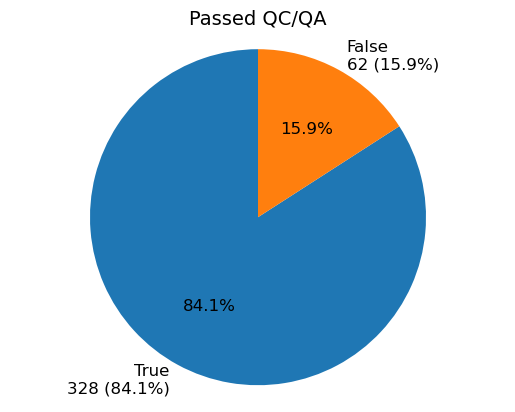

In [4]:
# let's create some summary tables, first pie chart of QC pass/fail
data = dict(QC_stats_df.passed_curation.value_counts())
total = sum(data.values())

# Calculate percentages
percentages = {key: (value / total) * 100 for key, value in data.items()}

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(
    data.values(),
    labels=[f"{key}\n{value} ({percentages[key]:.1f}%)" for key, value in data.items()],
    autopct='%.1f%%', 
    startangle=90, 
    textprops={'fontsize': 12}
)
ax.set_title('Passed QC/QA', fontsize=14)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Display the chart
plt.show()

In [39]:
mini.sum()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

metabolism = 0.1195440342362829
noise = 0.007660433243350084
regulatory = 0.014324299634952964
single_gene = 0.04743888006012209
stress_response = 0.08357518603903247
structural = 0.03709683622323878
translation = 0.08050350730730516
transport = 0.0540928237809557
uncharacterized = 0.0644155448596484


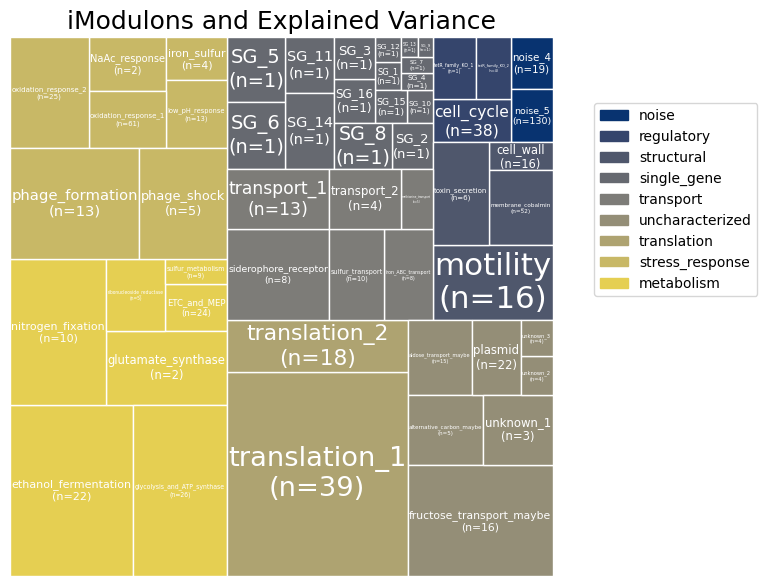

In [46]:
# explained variance treemap plot
df = ica_data.imodulon_table
df['labels'] = [index + '\n(n='+str(size)+')' for (index, size) in zip(df.index, ica_data.imodulon_table.imodulon_size)]
df = df.sort_values(by = 'category')

# Dynamically generate a color palette for unique categories
cat_to_exp = {}
for cat, mini in df.groupby('category'):
    cat_to_exp.update({cat : mini['explained_variance'].sum()})
unique_categories = [k for k, _ in sorted(cat_to_exp.items(), key = lambda x : x[1])]
palette = sns.color_palette('cividis', len(unique_categories))  # 'tab20' gives up to 20 distinct colors
color_map = dict(zip(unique_categories, palette))

# Map colors to categories
colors = df['category'].map(color_map)
colors2 = {k : 'blue' for k, _ in colors.items()}
# Create the treemap
fig, ax = plt.subplots(figsize=(7,7))
trc = tr.treemap(ax, df, area = 'explained_variance', labels = 'labels',
           cmap=color_map, fill='category', levels = ['category', 'labels'],
           rectprops=dict(ec='w'),
           textprops=dict(c='w'))

# make a legend
handles = sorted(trc.handles['labels'], 
                 key=lambda x: (x.get_ec(),x.get_label()))
legend = fig.legend(handles=[handles[i] for i in range(len(handles))],
          ncol=1, loc='lower left', bbox_to_anchor=(0.95, 0.5))

# Customize the plot
plt.title('iModulons and Explained Variance', fontsize=18)
plt.axis('off')  # Remove axes
plt.savefig('../figures/overall_iM_variance.pdf', transparent = True)
plt.show()

AttributeError: 'str' object has no attribute 'set_facecolor'

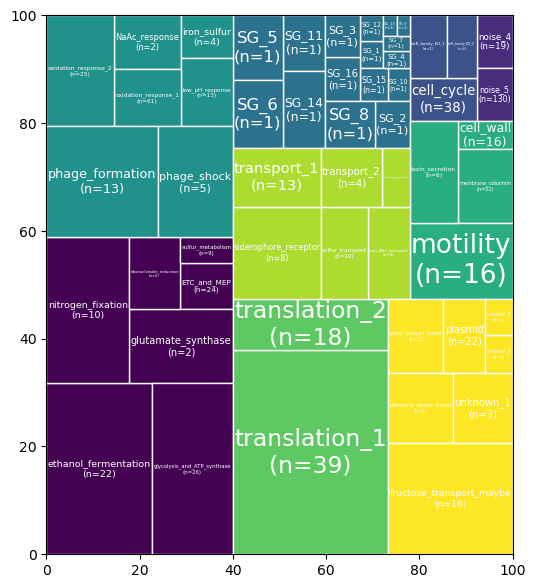

In [13]:
import matplotlib.pyplot as plt
import mpl_extra.treemap as tr
import seaborn as sns

# Sample data setup (assuming ica_data is already defined elsewhere)
df = ica_data.imodulon_table
df['labels'] = [index + '\n(n='+str(size)+')' for (index, size) in zip(df.index, ica_data.imodulon_table.imodulon_size)]
df = df.sort_values(by='category')

# Dynamically generate a color palette for unique categories
unique_categories = df['category'].unique()
palette = sns.color_palette('Greens', len(unique_categories))  # 'tab20' gives up to 20 distinct colors
color_map = dict(zip(unique_categories, palette))

# Map colors to categories
colors = df['category'].map(color_map)

# Create the treemap
fig, ax = plt.subplots(figsize=(7,7), dpi=100, subplot_kw=dict(aspect=1.156))
trc = tr.treemap(ax, df, area='explained_variance', labels='labels',
                 fill='category', levels=['category', 'labels'],
                 rectprops=dict(ec='w'),
                 textprops=dict(c='w'))

# Now manually adjust the colors of the cells
for patch, category in zip(trc.patches, df['category']):
    patch.set_facecolor(color_map[category])  # Set the color for each patch

# Make a legend
handles = sorted(trc.handles['labels'], 
                 key=lambda x: (x.get_ec(), x.get_label()))
legend = fig.legend(handles=[handles[i] for i in range(len(handles))],
                   ncol=1, loc='lower left', bbox_to_anchor=(0.85, 0.5))

# Customize the plot
plt.title('iModulons and Explained Variance', fontsize=18)
plt.axis('off')  # Remove axes
plt.savefig('../figures/overall_iM_variance.pdf', transparent=True)
plt.show()
